In [375]:
# import turtle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
plt.rcParams['figure.figsize'] = [10, 10] # adjust this to get a good fig size depending on the display you're using...

import csv
import time
import argparse
import random as rng
from enum import Enum

In [376]:
Divide = Enum('Divide', [('HORIZONTAL', 0), ('VERTICAL', 1)])
Orientate = Enum('Orientate', [('NORTH', 0), ('EAST', 1), ('SOUTH', 2), ('WEST', 3)])

In [377]:
class Table :
    def __init__(self, x_length, y_length, divide) :
        self.x_length = x_length
        self.y_length = y_length
        self.divide = divide
        if divide == Divide.HORIZONTAL : assert(y_length == 2)
        else : assert(x_length == 2)
        self.places = []
        self.fitness = 0
    def add_place(self, place) :
        self.places.append(place)

In [378]:
class Place:
    def __init__(self, x, y, orientate) :
        self.x = x
        self.y = y
        self.orientate = orientate
        self.student = 0
        self.adjacent = 0
        self.opposite = 0
    def assign_student(self, student) :
        self.student = student
    def set_adjacent(self, adjacent) :
        self.adjacent = adjacent
    def set_opposite(self, opposite) :
        self.opposite = opposite

In [379]:
class Student :
    def __init__(self) :
        self.attributes = {}
    def set_attribute(self, key, value) :
        self.attributes[key] = value
    def get_attribute(self, key) :
        return self.attributes[key]

In [380]:
class Rule:
    def __init__(self, attribute, boolean) :
        self.attribute = attribute
        self.boolean = boolean

In [381]:
def print_progress_bar (current_fitness, target_fitness, best_fitness, decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    current_percent = ("{0:." + str(decimals) + "f}").format(100 * (current_fitness / float(target_fitness)))
    best_percent = ("{0:." + str(decimals) + "f}").format(100 * (best_fitness / float(target_fitness)))
    filledLength = int(length * current_fitness // target_fitness)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{"Current: "} |{bar}| {current_percent}% {"Best: "} {best_percent}%', end = printEnd)

In [382]:
def str2bool(str) :
    return str.lower() in ("t", "true", "1")

In [383]:
def parse_rules(rule_strings) :
    rules = []
    if rule_strings:
        for rule_string in rule_strings:
            attribute, boolean = parse_rule(rule_string)
            rules.append(Rule(attribute, boolean))
    return rules

In [384]:
def read_students() :
    with open(args.student_file, 'r', encoding='utf-8-sig') as file:
        reader = csv.reader(filter(lambda row: row[0]!='#', file))
        keys = next(reader)
        students = []
        for row in reader :
            s = Student()
            for i in range(len(row)) :
                s.set_attribute(keys[i], row[i])
            students.append(s)
            if(len(students) == n_places) :
                break
    global n_students
    n_students = len(students)
    return students

In [385]:
def draw_classroom(n_cols, n_rows):
    turtle.penup()
    turtle.goto(START_X, START_Y)
    turtle.pendown()
    for row in range(n_rows):
        for col in range(n_cols):
            for _ in range(4):
                turtle.forward(args.place_size)
                turtle.right(90)
            turtle.forward(args.place_size)
        turtle.penup()
        turtle.backward(args.place_size * n_cols)
        turtle.right(90)
        turtle.forward(args.place_size)
        turtle.left(90)
        turtle.pendown()
    turtle.penup()
    screen.update()

In [386]:
def assign_place(place) :
    values = list(place.student.attributes.values())
    n_items =  min(3, len(values))
    adjust_vertical = n_items * 0.3
    label = ""
    for i in range(0, n_items) :
        label += values[i] + "\n"
    turtle.goto(START_X + (place.x * args.place_size) + (0.1 * args.place_size), START_Y - (place.y * args.place_size) - (adjust_vertical * args.place_size))
    turtle.pendown()
    turtle.write(label, font=('Arial', args.font_size, 'normal'))
    turtle.penup()

In [387]:
def draw_place(place):
    turtle.penup()
    turtle.goto(START_X + (place.x * args.place_size), START_Y - (place.y * args.place_size))
    turtle.pendown()
    if place.student == 0 :  turtle.fillcolor("darkgray")
    elif "colour" in place.student.attributes : 
        turtle.fillcolor(place.student.get_attribute("colour"))
    else : turtle.fillcolor("lightblue")
    turtle.begin_fill()
    for side in range(4):
        if side == place.orientate.value :
            turtle.forward(0.5 * args.place_size)
            turtle.right(60)
            turtle.forward(0.2 * args.place_size)
            turtle.right(120)
            turtle.forward(0.2 * args.place_size)
            turtle.right(120)
            turtle.forward(0.2 * args.place_size)
            turtle.right(60)
            turtle.forward(0.5 * args.place_size)
        else :
            turtle.forward(args.place_size)
        turtle.right(90)
    turtle.end_fill()
    turtle.penup()
    if place.student != 0 :
        assign_place(place)

In [388]:
def draw_floorplan(floorplan) :
    for x in range(args.n_rows) : 
        for y in range(args.n_cols) :
            if floorplan[x][y] != 0 :
                draw_place(floorplan[x][y])
    screen.update()

In [389]:
def get_place_text(place) :
    values = list(place.student.attributes.values())
    n_items =  min(3, len(values))
    adjust_vertical = n_items * 0.3
    label = ""
    for i in range(0, n_items) :
        label += values[i] + "\n"
    return label

In [390]:
def mpl_draw_floorplan(floorplan) :
    
    fig, ax = plt.subplots()
    rectangles = {}
    count = 0   
    
    for x in range(args.n_rows) : 
        for y in range(args.n_cols) :
            if floorplan[x][y] != 0 :
                colour = "darkgray"
                if floorplan[x][y].student != 0 :
                    label = get_place_text(floorplan[x][y])  
                    if "colour" in floorplan[x][y].student.attributes : 
                        colour = floorplan[x][y].student.get_attribute("colour")
                else :
                    label = count
                rectangles[label] = mpatch.Rectangle((x, y), 1, 1, color=colour)
                count = count + 1

    for r in rectangles:
        ax.add_artist(rectangles[r])
        rx, ry = rectangles[r].get_xy()
        cx = rx + rectangles[r].get_width()/2.0
        cy = ry + rectangles[r].get_height()/2.0
        ax.annotate(r, (cx, cy), color='w', weight='bold', fontsize=10, ha='center', va='center')
    
    ax.set_xlim((0, args.n_rows))
    ax.set_ylim((0, args.n_cols))
    ax.set_aspect('equal')
    # ax.axis('off')  # hide the surrounding axes
    plt.show()

In [391]:
def find_adjacent(place) :
    if place.orientate in (Orientate.NORTH, Orientate.SOUTH) :
        if (place.x - 1 != -1) and (classroom[place.x -1][place.y] != 0) :
            return classroom[place.x - 1][place.y]
        elif (place.x + 1 != args.n_cols) and (classroom[place.x + 1][place.y] != 0) :
            return classroom[place.x + 1][place.y]
    elif place.orientate in (Orientate.EAST, Orientate.WEST) :
        if (place.y - 1 != -1) and (classroom[place.x][place.y - 1] != 0) :
            return classroom[place.x][place.y - 1]
        elif (place.y + 1 != args.n_cols) and (classroom[place.x][place.y + 1] != 0) :
            return classroom[place.x][place.y + 1]

In [392]:
def find_opposite(place) :
    if place.orientate == Orientate.NORTH :
        return classroom[place.x][place.y - 1]
    elif place.orientate == Orientate.EAST : 
        return classroom[place.x + 1][place.y]
    elif place.orientate == Orientate.SOUTH : 
        return classroom[place.x][place.y + 1]
    elif place.orientate == Orientate.WEST : 
        return classroom[place.x - 1][place.y]

In [393]:
def add_table(x_start, y_start, table) :
    tables.append(table)
    for x in range(x_start, x_start + table.x_length) :
        for y in range(y_start, y_start + table.y_length) :
            if table.divide == Divide.HORIZONTAL :
                orientate = (Orientate.SOUTH if y == y_start  else Orientate.NORTH)
            else :
                orientate = (Orientate.EAST if x == x_start  else Orientate.WEST)
            place = Place(x, y, orientate)
            global n_places
            n_places = n_places + 1
            classroom[x][y] = place
            table.add_place(place)
    for place in table.places :
        place.set_adjacent(find_adjacent(place))
        place.set_opposite(find_opposite(place))

In [394]:
def generate_random_table() :
    coin = rng.randint(0, 1)
    if coin == 0 :
        divide = Divide.HORIZONTAL 
        x_length = rng.randint(2, 4)
        y_length = 2
    else :
        divide = Divide.VERTICAL
        x_length = 2
        y_length = rng.randint(2, 4)
    return Table(x_length, y_length, divide)

In [395]:
def space_is_empty(x, y, table) : 
    for i in range(x, x + table.x_length + 1) :
        for j in range(y, y + table.y_length + 1) :
            if classroom[i][j] != 0 : return False
            if classroom[i - 1][j] != 0 : return False
            if classroom[i][j - 1] != 0 : return False
            if classroom[i - i][j - 1] != 0 : return False
            if j + 1 != args.n_cols :
                if classroom[i][j + 1] != 0 : return False
                if classroom[i - 1][j + 1] != 0 : return False
            if i + 1 != args.n_rows :
                if classroom[i + 1][j] != 0 : return False

In [396]:
def check_boundary(x, y, table) :
    if (x == 0 or x + table.x_length == args.n_cols +1) and table.divide == Divide.VERTICAL : return False
    if (y == 0 or y + table.y_length == args.n_rows + 1) and table.divide == Divide.HORIZONTAL : return False
    if (x + table.x_length <= args.n_cols) and (y + table.y_length <= args.n_rows) : return True
    else : return False

In [397]:
def generate_random_floorplan() :
    for x in range(0, args.n_cols) :
        for y in range(0, args.n_rows) :       
            table = generate_random_table()
            if check_boundary(x, y, table) != False :
                if space_is_empty(x, y, table) != False :
                    add_table(x, y, table)
    if(args.log_level > 1) : print("Table count = " + str(len(tables)))
    if(args.log_level > 1) : print("Place count = " + str(n_places))

In [398]:
def do_random_assignment() :
    students = read_students()
    assert n_places == n_students
    for table in tables :
        for place in table.places :
            index = rng.randint(0, len(students) - 1)
            student = students[index]
            del students[index]
            place.student = student

In [399]:
def swap_students(place_a, place_b) :
    student_temp = place_a.student
    place_a.assign_student(place_b.student)
    place_b.assign_student(student_temp)

In [400]:
def student_swap_table(table_a, table_b) :
    place_a = table_a.places[rng.randint(0, (table_a.x_length * table_a.y_length) - 1)]
    place_b = table_b.places[rng.randint(0, (table_b.x_length * table_b.y_length) - 1)]
    swap_students(place_a, place_b)

In [401]:
def student_swap_table_random(tables) :
    for i in range(0, len(tables)) :
        a = i
        b = i + 1 if i != len(tables) - 1 else 0
        if tables[a] == tables[b] : rng.shuffle(tables[a].desks)
        else : student_swap_table(tables[a], tables[b])

In [402]:
def apply_rule(rule, student_a, student_b) :
    return 0 if rule.boolean != (student_a.get_attribute(rule.attribute) == student_b.get_attribute(rule.attribute)) else 1

In [403]:
def apply_ruleset(ruleset, student_a, student_b) :
    for rule in ruleset :        
        if apply_rule(rule, student_a, student_b) == 0 : return False

In [404]:
def compute_table_fitness(table) :
    table.fitness = 0
    for place in table.places :
        for rule in adj_rules :
            table.fitness = table.fitness + apply_rule(rule, place.student, place.adjacent.student)
        for rule in ops_rules :
            table.fitness = table.fitness + apply_rule(rule, place.student, place.opposite.student)

In [405]:
def process_table(table) :
    for place in table.places :
        # apply multiple rulsets here!
        fit = apply_ruleset(adj_rules, place.student, place.adjacent.student)
        fit = apply_ruleset(ops_rules, place.student, place.opposite.student)
        if fit == False :
            if (table.x_length > 2) or (table.y_length > 2) :
                coin = rng.randint(0, 2)
                if coin == 0 : swap_students(place, place.opposite)
                elif coin == 1 : swap_students(place, place.adjacent)
                else : student_swap_random(table, place)
            else : swap_students(place, place.opposite)
            return

In [414]:
def solve() :
    iterations = 0
    perfect_fitness = n_places * (len(adj_rules) + len(ops_rules))
    best_fitness = 0
    solution_found = False    
    start_time = time.time()

    while iterations < args.max_iterations :
        # Apply rules and do swaps
        for table in tables :
            process_table(table)        

        # Compute table fitness
        for table in tables :
            compute_table_fitness(table)

        # Compute solution fitness
        solution_fitness = 0
        for table in tables :
            solution_fitness = solution_fitness + table.fitness

        if(args.log_level > 1) : 
            if solution_fitness > best_fitness: best_fitness = solution_fitness
            print_progress_bar(solution_fitness, args.target_fitness, best_fitness, length = 50)
            
        # Check fitness
        if solution_fitness >= args.target_fitness :
            solution_found = True
            exec_time = (time.time() - start_time)
            break
        else :
            if iterations % args.migration_interval == 0 :
                student_swap_table_random(tables)

        iterations = iterations + 1

    # End, do reporting
    if (iterations == args.max_iterations) or (solution_found == True) :
        exec_time = (time.time() - start_time)
        if (solution_found == True) and (args.log_level > 0) :
            percentage_fitness = (solution_fitness / perfect_fitness) * 100
            print("\nSUCCESS, " + str(round(percentage_fitness, 2)) + "% after " + str(iterations) + " iterations, in " +str(round(exec_time, 2)) + " seconds. Throughput: " + str(round(iterations / exec_time, 2)))
            # screen.update()
        elif (solution_found == False) and (args.log_level > 0) :
            print("\nFAIL, no solution after " + str(iterations) + " iterations, in " +str(round(exec_time, 2)) + " seconds. Throughput: " + str(round(iterations / exec_time, 2)))
    if args.log_level == 0 : print(str(solution_found) + "," + str(iterations) + "," + str(round(iterations / exec_time, 2)) +"," + str(exec_time))

In [407]:
def student_swap_random(table, place) :
    index = rng.randint(0, len(table.places) - 1)
    swap_students(place, table.places[index])

In [408]:
def click_handler(x, y) :
    do_random_assignment()
    if args.display_level > 0 : draw_floorplan(classroom)
    solve()
    if args.display_level > 0 : draw_floorplan(classroom)
    screen.onclick(click_handler)

In [409]:
def run_display() :
    global screen
    screen = turtle.Screen()
    screen.setup(width=args.canvas_width, height=args.canvas_height)
    turtle.title("pyseater")
    turtle.Turtle(visible=False)
    screen.tracer(False)
    turtle.penup()
    draw_classroom(args.n_cols, args.n_rows)
    draw_floorplan(classroom)
    screen.onclick(click_handler)
    turtle.hideturtle()
    screen.mainloop()

In [410]:
def run_batch() :
    print("solved,iterations,throughput,exec_time")
    for _ in range(0, args.batch_size) :
        do_random_assignment()
        solve()

Applying rules:
	adjacent: gender = False
	adjacent: language = False
	adjacent: game = False
Target fitness set to 100%


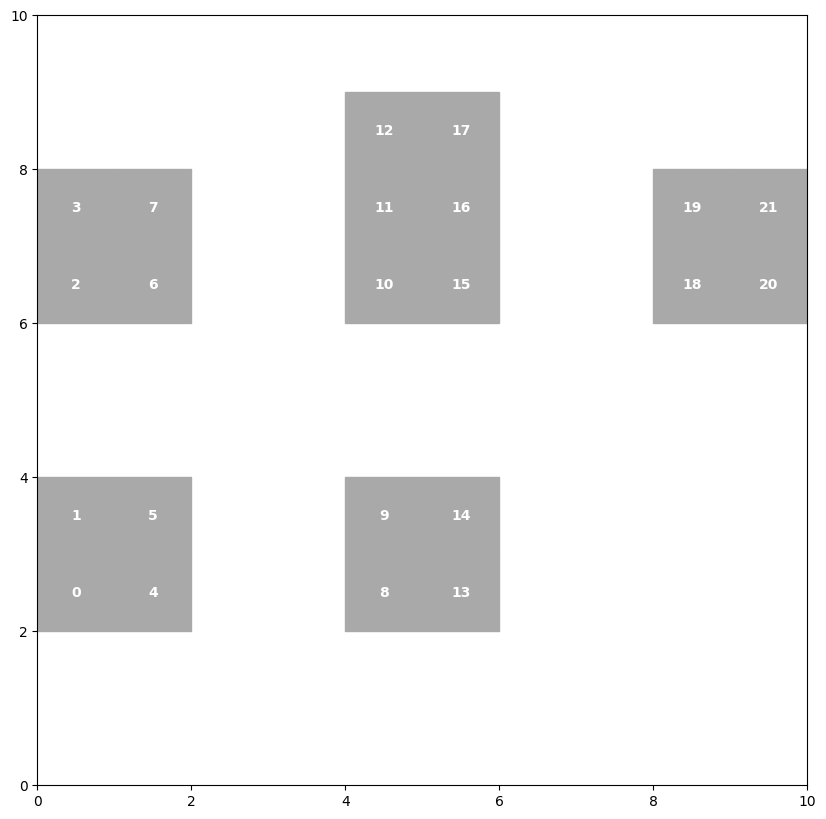

In [411]:
parser = argparse.ArgumentParser(description="pyseater - generate classroom seating plans according to some rules")
parser.add_argument("--adj_rules", metavar="ATTRIBUTE=BOOL", nargs='+', help="specify a list of rules for adjacent desks as key=value pairs, e.g. language=false.")
parser.add_argument("--ops_rules", metavar="ATTRIBUTE=BOOL", nargs='+', help="specify a list of rules for opposite desks as key=value pairs, e.g. language=false.")
parser.add_argument("--seed", help="provide a random seed to get deterministic behaviour", type=int)
parser.add_argument("--frame_delay", help="delay after each refresh, only relevant when --show is set", default=0.05, type=float)
parser.add_argument("--place_size", help="size in pixels of a seating place, i.e. one square on the grid", default=70, type=int)
parser.add_argument("--font_size", help="font size of text displayed on places", default=8, type=int)
parser.add_argument("--n_rows", help="the number of rows in the floorplan", default=10, type=int)
parser.add_argument("--n_cols", help="the number of columns in the floorplan", default=10, type=int)
parser.add_argument("--max_iterations", help="maximum solver iterations before giving up", default=1000000, type=int)
parser.add_argument("--target_fitness", help="target solution fitness as a percentage, e.g 95", default=100, type=float)
parser.add_argument("--student_file", help="csv file containing student data", default="data/students.csv")
parser.add_argument("--migration_interval", help="number of iterations between random student table migrations", default=5, type=int)
parser.add_argument("--canvas_width", help="width of the display canvas in pixels", default=800, type=int)
parser.add_argument("--canvas_height", help="height of the display canvas in pixels", default=800, type=int)
parser.add_argument("--batch_size", help="generate batch size seating plans, ", default=0, type=int)
parser.add_argument("--random_tables", help="fill floorplan with random tables", action="store_true")
parser.add_argument("--log_level", help="logging increases with log level", default=1, type=int)
parser.add_argument("--display_level", help="increasing level of screen updates", default=1, type=int)

# passing empty string means it will use all the defaults which is handy in ipython where we have no terminal args
args = parser.parse_args("") 
adj_rules = parse_rules(args.adj_rules)
ops_rules = parse_rules(args.ops_rules)

# Need to put this somewhere else
args.student_file = "/home/tim/mysrc/pyseater/data/students.csv"

tables = []
n_places = 0
n_students = 0

if args.batch_size != 0 :
    args.display_level = 0
    args.log_level = 0

if len(adj_rules) == 0 :
    adj_rules.append(Rule("gender", False))
    adj_rules.append(Rule("language", False))
    adj_rules.append(Rule("game", False))

# if len(ops_rules) == 0 :
#     ops_rules.append(Rule("gender", False))
#     ops_rules.append(Rule("language", False))
#     ops_rules.append(Rule("game", False))

if(args.log_level > 0) : print("Applying rules:")
for adj_rule in adj_rules :
    if(args.log_level > 0) : print("\tadjacent: " + str(adj_rule.attribute) + " = " + str(adj_rule.boolean))
for ops_rule in ops_rules :
    if(args.log_level > 0) : print("\topposite:" + str(ops_rule.attribute) + " = " + str(ops_rule.boolean))

if args.seed :
    if(args.log_level > 0) : print("Seed will be set to " + str(args.seed))
    rng.seed(args.seed)

START_X = -(args.place_size * (0.5 * args.n_cols))
START_Y = (args.place_size * (0.5 * args.n_rows))

classroom = [[0 for i in range(args.n_cols)] for j in range(args.n_rows)]

if args.random_tables == True :
    if(args.log_level > 0) : print("Generating random floorplan.")
    generate_random_floorplan() 
else :
    add_table(0, 2, Table(2, 2, Divide.HORIZONTAL))
    add_table(4, 2, Table(2, 2, Divide.VERTICAL))
    add_table(8, 6, Table(2, 2, Divide.HORIZONTAL))
    add_table(4, 6, Table(2, 3, Divide.VERTICAL))
    add_table(0, 6, Table(2, 2, Divide.HORIZONTAL))

if args.target_fitness :
    if(args.log_level > 0) : print("Target fitness set to " + str(args.target_fitness) + "%")
args.target_fitness = (args.target_fitness / 100) * (n_places * (len(adj_rules) + len(ops_rules)))

#if args.batch_size != 0 : run_batch()
#else : run_display()

# New matplotlib version
mpl_draw_floorplan(classroom)

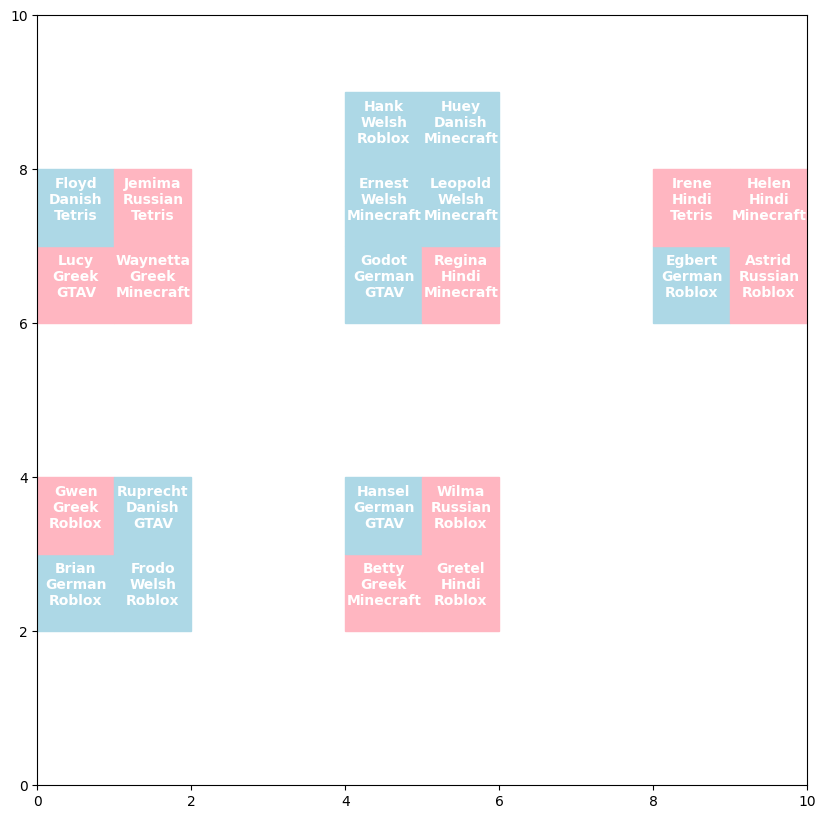

In [412]:
do_random_assignment()
mpl_draw_floorplan(classroom)

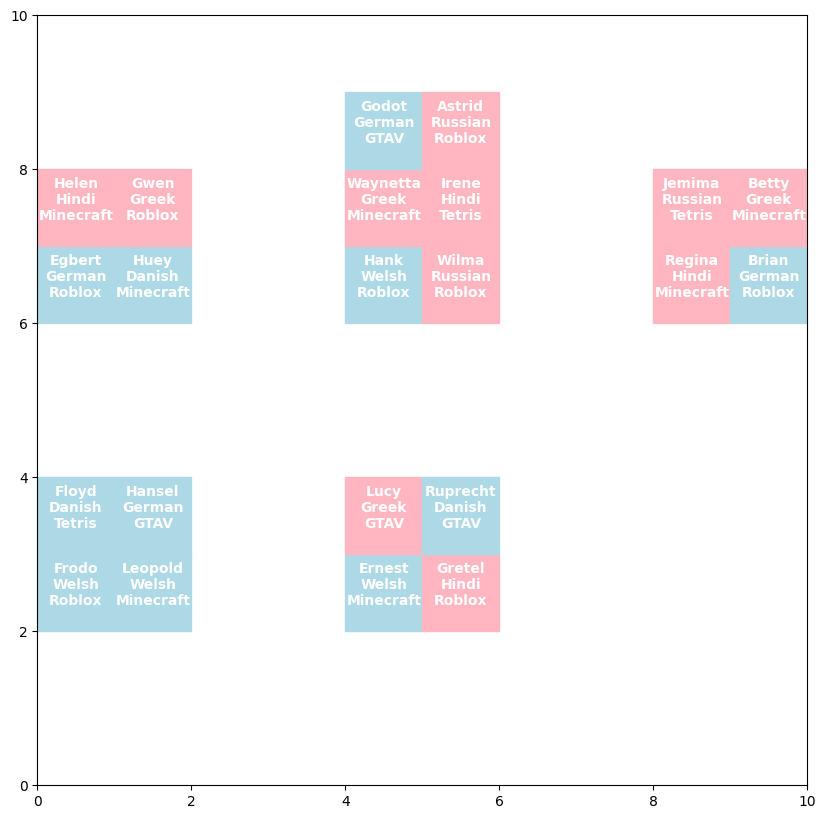


FAIL, no solution after 1000000 iterations, in 223.34 seconds. Throughput: 4477.49


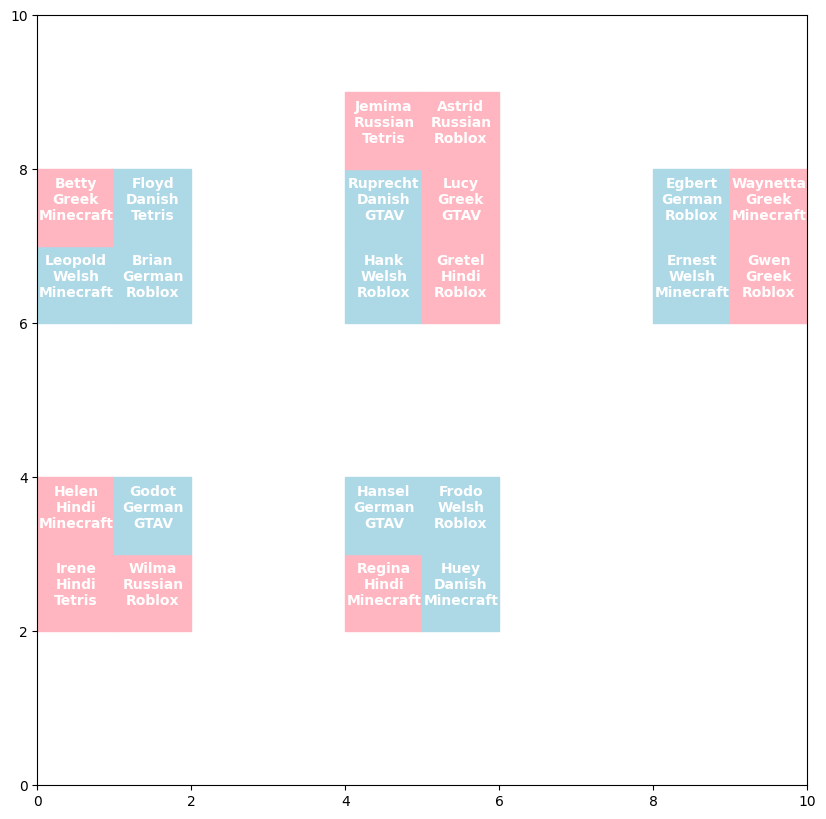

In [416]:
do_random_assignment()
mpl_draw_floorplan(classroom)
solve()
mpl_draw_floorplan(classroom)